<a href="https://colab.research.google.com/github/jsboss5/Aryeo-Amenity-Detection/blob/master/Airbnb_Rep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Up until line 14 it's just installing**

In [0]:
# Import Packages
import os
import pandas as pd
import random
import cv2

In [0]:
# # Install Detectron2 (locally)
import sys
!pip3 install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install cython pyyaml==5.1
!pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip3 install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [0]:
import torch, torchvision
torch.__version__
!gcc --version

In [0]:
# Build Detectron2 from source
!pip3 install 'git+https://github.com/facebookresearch/detectron2.git'

In [0]:
# Import Detectron2/requirements
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import torch/torchvision
import torch, torchvision
torch.__version__
!gcc --version

In [0]:
#install wget
!pip3 install wget


In [0]:
#install opencv
!pip3 install opencv-python


In [0]:
!pip3 install tqdm 

In [0]:
!pip3 install awscli

In [0]:
# # This doesnt needed to be done anymore because i mounted these in google drive
# Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html
# Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# # Class Names (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

**Let's start Manipulating Data!!!!**

In [0]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

In [0]:
#Download only coffee maker training set into CoffeMaker small model google drive foler
%cd /content/drive/My Drive/CoffeeMaker Small Model

In [0]:
#download all coffeemaker images for train and test.  -   .
!python3 downloadOI.py --classes 'Coffeemaker' --dataset train
!python3 downloadOI.py --classes 'Coffeemaker' --dataset validation


In [0]:
#Replaces underscores with spaces - matches airbnb classes with those from website
for i in range(len(subset)):
  subset[i] = subset[i].replace("_", " ")

print(subset)

In [0]:
#convert this list to a string for the command line
subset_string = str()
for amenity in subset:
  subset_string += str(amenity) + ","
subset_string = subset_string[:len(subset_string)-1]
print(subset_string)

In [0]:
#labeled images directory - download images here once - already DID THIS
cd /content/drive/My Drive/Labeled Images

In [0]:
#Downloads all of the validation data - already done!
!python3 downloadOI.py --classes 'Toilet,Swimming pool,Bed,Billiard table,Sink,Fountain,Oven,Ceiling fan,Television,Microwave oven,Gas stove,Refrigerator,Kitchen & dining room table,Washing machine,Bathtub,Stairs,Fireplace,Pillow,Mirror,Shower,Couch,Countertop,Coffeemaker,Dishwasher,Sofa bed,Tree house,Towel,Porch,Wine rack,Jacuzzi' --dataset validation



In [0]:
#top layer - default workspace
cd /content


In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Change data to Detectron2 Style**

First in order to change to get everything into detectron2 style, we must find the image id for every single image - I'm going to do this for the Coffee set first

The function is get_image_ids

In [0]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder)]

In [0]:
#get into the val images directory for coffee
%cd /content/drive/My Drive/CoffeeMaker Small Model

In [0]:
#get into the val images directory with all val images
%cd /content/drive/My Drive/Labeled Images

In [0]:
val_image_ids = get_image_ids("validation")  #stores list of validation ids into val_image_ids
print(val_image_ids[:10])                 #prints first 10
len(val_image_ids)


In [0]:
#This view shows the csv converting label name to the actual class name for
#all 600 classes on the open source thing
pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])

Now we are going to add a classname column to the existing csv file in addition to a class index column

In [0]:
 #Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])
    
    # Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassID"] = pd.Categorical(annot_file["ClassName"]).codes
    
    return annot_file

In [0]:
#without target classes
# runs it on the entire validation set - include the target_classes = subset) if you want only specified classes
# I'm not sure if the validation set should include images from other classes though - i think it should 
%%time
val_annot = format_annotations("validation", "validation-annotations-bbox.csv")
val_annot.head()
print(val_annot)

In [0]:
#with only target classes
%%time
val_annot = format_annotations("validation", "validation-annotations-bbox.csv", target_classes=subset)
val_annot.head()
print(val_annot)

In [0]:
len(val_annot)


In [0]:
#it's interesting to compare these values for when val_annot includes only subset classes and not 
#not subset classes
val_annot["ClassName"].value_counts()



**Convert Coordinates from relative to absolute!**

In [0]:
# Write function to convert bounding boxes from relative to absolute
# Takes in x0, y0, x1, y1, height and width and converts from relative to absolute
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.multiply(bbox[0], width) # x0
    bbox[1] = np.multiply(bbox[1], height) # y0
    bbox[2] = np.multiply(bbox[2], width) # x1
    bbox[3] = np.multiply(bbox[3], height) # y1
    return bbox

In [0]:
#Literally just to show how it works - creates fake bbox 
bbox = np.array([0.27286136, 0.40486726, 0.84070796, 1.        ])
bbox[0] = np.multiply(bbox[0], 100)
bbox

In [0]:
#converts the fake bounding box from above and converts it to absolute coordinates
bbox_abs = rel_to_absolute(bbox, 100, 200)
bbox_abs


**Start Creating Dataset dictionaries**

In [0]:
# Import CV2 for getting height & width of image
import cv2

# Import Detectron2 BoxMode for bounding boxes style
from detectron2.structures import BoxMode

In [0]:
# Next: functionise the below code
def get_image_dicts(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on data in annotations.
    
    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    # Get annotations (automatically picks annotations CSV based on image_folder)
    annotations = format_annotations(image_folder, 
                                     image_folder+"-annotations-bbox.csv", 
                                     target_classes=subset) # TODO: this uses a global variable
    
    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for img in img_ids:
        record = {}
        
        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = img
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"]
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)
    return img_dicts

In [0]:
%%time
val_img_dicts = get_image_dicts("validation")
print(len(val_img_dicts))
print(val_img_dicts)

In [0]:
import random
number = round(random.randint(0, len(val_img_dicts)))
print(number)
val_img_dicts[number]

In [0]:
val_annot.head()


In [0]:
val_annot = val_annot.sort_values("ClassID")
val_annot.head()


In [0]:
#This literally just puts all the classIDs as values in a dictionary
# and then prints them so you can see them as a list
things = val_annot.set_index("ClassID").to_dict()["ClassName"]
thing_list = list(things.values())
thing_list

In [0]:
# Register Data in Detectron2 style
from detectron2.data import DatasetCatalog, MetadataCatalog

In [0]:
for d in ["validation"]:
    # dataset_name, mapper function
    DatasetCatalog.register(d + "_dataset", lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d + "_dataset").set(thing_classes=thing_list)
val_metadata = MetadataCatalog.get("validation_dataset")

In [0]:
MetadataCatalog.list()


In [0]:
#Not really sure what metadata does though I know it is data about data
val_metadata

**View the Annotated Images!!!!**

In [0]:
#I just chose an image to visualize using python display
from IPython.display import Image
Image("validation/ff170cdebcd8d899.jpg")

In [0]:
# Make a function to view images
def view_images(image_dict, random_image=True, n_images=1):
    plt.figure(figsize=(30,30))
    if random_image:
        for i, d in enumerate(random.sample(image_dict, n_images)):
            img=cv2.imread(d["file_name"])
            visualizer = Visualizer(img[:, :, :], 
                            metadata=val_metadata, 
                            scale=0.6)
            vis = visualizer.draw_dataset_dict(d)
            ax = plt.subplot(n_images, 1, i+1)
            plt.imshow(vis.get_image()[:, :, ::-1])
            plt.axis("off")

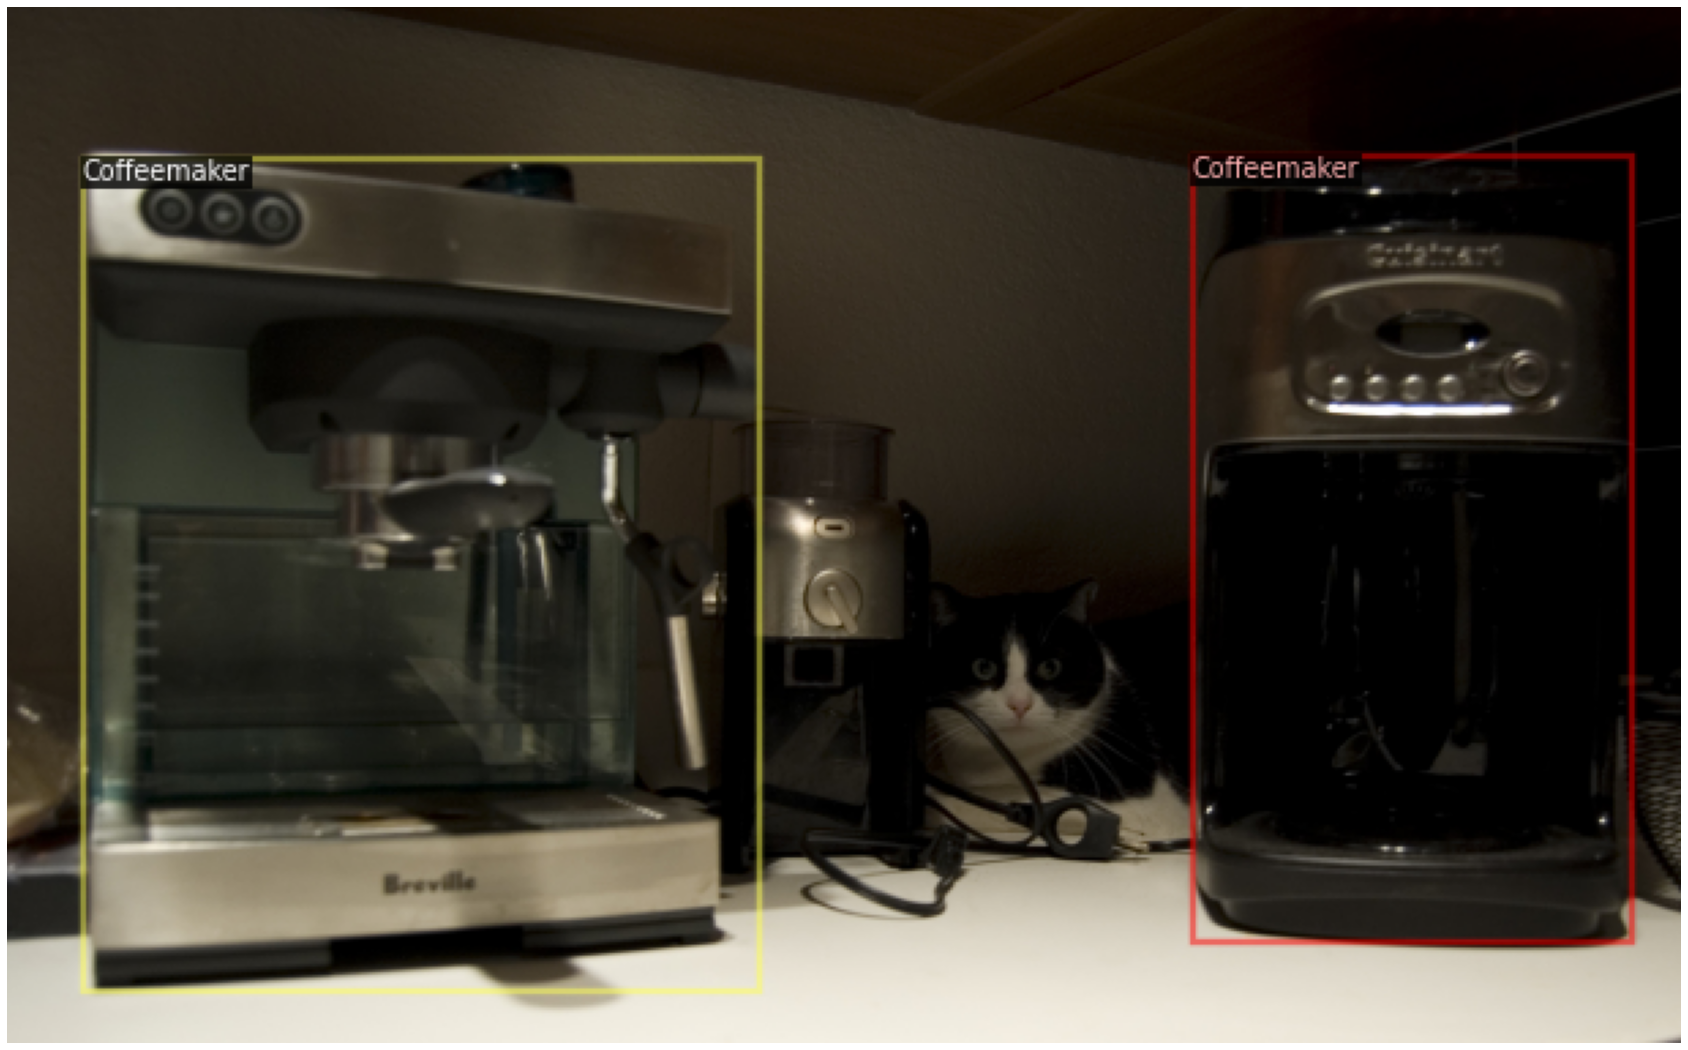

In [105]:
view_images(val_img_dicts)
